### Preparation

In [623]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve,roc_auc_score,auc,precision_recall_curve,average_precision_score,accuracy_score
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings("ignore")
def clf_select(name):
    if name =='DT':
        clf = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, criterion='gini')
    elif name =='DT_cv':
        tree_para = {'max_depth': [3,5,7,9]}
        clf = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=5)
    elif name == 'SVM':
        clf = SVC(kernel='linear', probability=True, C=0.8)
    elif name == 'SVM_cv':
        tree_para = { 'C':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
        clf = GridSearchCV(SVC(kernel= 'rbf',probability=True), tree_para, cv=5)
    elif name == 'RF':
        clf = RandomForestClassifier(criterion='gini', max_depth=None, min_samples_split=2,n_estimators=1000) #rfc.get_params(deep=True)
    elif name == 'RF_cv':
        tree_para = {'n_estimators': [500, 1000, 1500]}
        clf = GridSearchCV(RandomForestClassifier(), tree_para, cv=5)
    elif name == 'LR':
        clf = LogisticRegression(penalty='l2',solver='liblinear')
    elif name == 'LR_cv':
        tree_para = {'C': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]}
        clf = GridSearchCV(LogisticRegression(penalty='l2',solver='liblinear'), tree_para, cv=5)
    return clf

def plot_AUROC(Y_test,Y_prob,F):
    fpr, tpr, thresholds = roc_curve(Y_test,Y_prob)
    roc_auc = auc(fpr, tpr)
    print('AUROC:',roc_auc)
    # plot ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(fpr, tpr, '-', color='blue', label='RandomForest AUC = {:.4f}'.format(roc_auc), lw=2)
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random Chance')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('ROC curve of ' + F)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.legend(loc='best',fontsize='small')
    plt.tight_layout()

    plt.savefig('figure/' + F + '_AUC.png',dpi=600)
    plt.show()
    plt.close()

def plot_AUPRC(Y_test,Y_prob,F):
    precision, recall, thresholds = precision_recall_curve(Y_test,Y_prob)
    aupr = auc(recall,precision)
    print('AUPRC:',aupr)
    # plot ROC curve
    plt.figure(figsize=(4,4))
    plt.plot(recall,precision, '-', color='blue', label='RandomForest AUPRC = {:.4f}'.format(aupr), lw=2)
    plt.plot([0, 1], [1, 0], '--', color=(0.6, 0.6, 0.6), label='Random Chance')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.title('AUPRC curve of ' + F)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend(loc='best',fontsize='small')
    plt.tight_layout()
    plt.savefig('figure/' + F + '_PRC.png',dpi=600)
    plt.show()
    plt.close()

### Load data

In [56]:
import random 
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import re

DeltaG = {'AA': -0.93, 'UU': -0.93, 'AU': -1.10, 'UA': -1.33, 'CU': -2.08, 'AG': -2.08, 'CA': -2.11, 'UG': -2.11, 'GU': -2.24,  'AC': -2.24, 'GA': -2.35,  'UC': -2.35, 'CG': -2.36, 'GG': -3.26, 'CC': -3.26, 'GC': -3.42, 'init': 4.09, 'endAU': 0.45, 'sym': 0.43}
DeltaH = {'AA': -6.82, 'UU': -6.82, 'AU': -9.38, 'UA': -7.69, 'CU': -10.48, 'AG': -10.48, 'CA': -10.44, 'UG': -10.44, 'GU': -11.40,  'AC': -11.40, 'GA': -12.44,  'UC': -12.44, 'CG': -10.64, 'GG': -13.39, 'CC': -13.39, 'GC': -14.88, 'init': 3.61, 'endAU': 3.72, 'sym': 0}

def antiRNA(RNA):
    antiRNA = []
    for i in RNA:
        if i == 'A' or i == 'a':
            antiRNA.append('T')
        elif i == 'U' or i == 'u' or i == 'T' or i == 't':
            antiRNA.append('A')
        elif i == 'C' or i == 'c':
            antiRNA.append('G')
        elif i == 'G' or i == 'g':
            antiRNA.append('C')
    return ''.join(antiRNA[::-1])

def Calculate_DGH(seq):
    DG_all = 0
    DG_all += DeltaG['init']
    DG_all += ((seq[0] + seq[len(seq)-1]).count('A') + (seq[0] + seq[len(seq)-1]).count('U')) * DeltaG['endAU']
    DG_all += DeltaG['sym'] if antiRNA(seq).replace('T','U') == seq else 0
    for i in range(len(seq) - 1):
        DG_all += DeltaG[seq[i] + seq[i+1]]
    DH_all = 0
    DH_all += DeltaH['init']
    DH_all += ((seq[0] + seq[len(seq)-1]).count('A') + (seq[0] + seq[len(seq)-1]).count('U')) * DeltaH['endAU']
    DH_all += DeltaH['sym'] if antiRNA(seq).replace('T','U') == seq else 0
    for i in range(len(seq) - 1):
        DH_all += DeltaH[seq[i] + seq[i+1]]
    return DG_all,DH_all

def Calculate_end_diff(siRNA):
    count = 0
    _5 = siRNA[:2] # 5'end
    _3 = siRNA[-2:] # 3' end
    if _5 in ['AC','AG','UC','UG']:
        count += 1
    elif _5 in ['GA','GU','CA','CU']:
        count -= 1
    if _3 in ['AC','AG','UC','UG']:
        count += 1
    elif _3 in ['GA','GU','CA','CU']:
        count -= 1
    
    return float('{:.2f}'.format(DeltaG[_5] - DeltaG[_3] + count * 0.45))
    

ShaData = pd.read_csv(r"./dataset/ShaDataset.csv", sep = ',')
ShaData.rename(columns = {ShaData.columns[0]:'mRNA',ShaData.columns[1]:'start',ShaData.columns[2]:'end',ShaData.columns[3]:'siRNA'},inplace = True)

print(sum(ShaData['Activ'] <= 50))
print(sum(ShaData['Activ'] <= 30))
print(sum(ShaData['Activ'] <= 10))

HuData = pd.read_csv("./dataset/2431siRNA.csv", sep = ',')
print(sum(100 * HuData['Normalized inhibitory activityb'] >= 50))
print(sum(100 * HuData['Normalized inhibitory activityb'] >= 70))
print(sum(100 * HuData['Normalized inhibitory activityb'] >= 90))

mRNA34 =  pd.read_csv("./dataset/34mRNA.csv", sep = ',')
HuData['Guide strand'] = [i.upper() for i in HuData['Guide strand']]
HuData['Guide strand'] = [i.replace('T','U') for i in HuData['Guide strand']]
HuData['antiRNA'] = HuData['Guide strand']
HuData['target mRNA'] = HuData['Guide strand']
for i in range(HuData.shape[0]):
    HuData.iloc[i,15] = antiRNA(HuData.iloc[i,15])

for i in range(HuData.shape[0]):
    for j in range(mRNA34.shape[0]):
        if re.search(HuData.iloc[i,15],mRNA34.iloc[j,1]) != None:
            HuData.iloc[i,16] = mRNA34.iloc[j,1]

HuData = HuData[HuData['target mRNA'] != mRNA34['cDNA insert sequence used for siRNA design'][7]].reset_index(drop=True)

mRNASha = pd.read_csv("./dataset/ShaDataset_mRNA.txt", sep = '\t',index_col=0)
mRNASha['len'] = [len(mRNASha['seq'][i]) for i in range(mRNASha.shape[0])]

ShaData['antiRNA'] = ShaData['siRNA']
ShaData['target mRNA'] = ShaData['mRNA']
for i in range(ShaData.shape[0]):
    ShaData['antiRNA'][i] = antiRNA(ShaData['antiRNA'][i])

for i in range(ShaData.shape[0]):
    ShaData.iloc[i,-1] = mRNASha.loc[ShaData.iloc[i,0],'seq']
    
efficacy = pd.read_csv('result/RBP_efficacy.txt',sep = '\t',header=0)
# HuData.to_csv('result/HuData.txt',sep='\t',index = None,header=True)
# ShaData.to_csv('result/ShaData.txt',sep='\t',index = None,header=True)

418
293
108
2000
1222
369


### RBP calculation

In [479]:
df = pd.read_csv('dataset/TF_bed_revise.txt',sep = '\t',header=None)
df.columns = [['mRNA','start_end','chr','strand']]
df['start'] = df['start_end']
df['end'] = df['start_end']
df['efficacy'] = df['start_end']
df['fullRNA'] = df['start_end']
df['ID'] = df['start_end']
for i in range(df.shape[0]):
    df.iloc[i,4] = df.iloc[i,1].strip().split(' ')[0]
    df.iloc[i,5] = df.iloc[i,1].strip().split(' ')[-1]

df.drop('start_end',axis = 1, inplace=True)
for i in range(df.shape[0]):
    df.iloc[i,5] = efficacy[efficacy['antiRNA'] == df.iloc[i,0]]['Label'].values[0]
    df.iloc[i,6] = efficacy[efficacy['antiRNA'] == df.iloc[i,0]]['cDNA'].values[0]
    df.iloc[i,7] = mRNA34[mRNA34['cDNA insert sequence used for siRNA design'] == df.iloc[i,6]].iloc[0,0].split('\n')[0].split(' ')[1].split('(')[0]
df = df[(df['ID'] != 'RAB6IP1').values].reset_index(drop=True)
df = df[(df['ID'] != 'SOST').values].reset_index(drop=True)
df = df[(df['ID'] != 'NOG').values].reset_index(drop=True)
df = df[(df['ID'] != 'P2RX3').values].reset_index(drop=True)
df.iloc[df[(df['ID'] == 'TC10').values[:,0]].index,-1] = 'RHOQ'
df.iloc[df[(df['ID'] == 'C6orf110').values[:,0]].index,-1] = 'TMEM63B'
df = df[(df['ID'] != 'RHOQ').values].reset_index(drop=True)
df.to_csv('result/RBP_result.txt',sep='\t',index=0)
df

,mRNA,chr,strand,start,end,efficacy,fullRNA,ID
0,GACCTCTTCTACGACGACTAC,chr19,+,541451,541471,0.827,CAAGGGGCTGCAGGAAGAGCCGGTCGAGGGATTCCGCGTGACACTG...,CDC34
1,AGACCTCTTCTACGACGACTA,chr19,+,541450,541470,0.893,CAAGGGGCTGCAGGAAGAGCCGGTCGAGGGATTCCGCGTGACACTG...,CDC34
2,GGCTCAGACCTCTTCTACGAC,chr19,+,541445,541465,0.372,CAAGGGGCTGCAGGAAGAGCCGGTCGAGGGATTCCGCGTGACACTG...,CDC34
3,CCGACGAGGGCTCAGACCTCT,chr19,+,541437,541457,0.517,CAAGGGGCTGCAGGAAGAGCCGGTCGAGGGATTCCGCGTGACACTG...,CDC34
4,GCGCCCGACGAGGGCTCAGAC,chr19,+,541433,541453,0.336,CAAGGGGCTGCAGGAAGAGCCGGTCGAGGGATTCCGCGTGACACTG...,CDC34
...,...,...,...,...,...,...,...,...
966,TGAAGACCTGAGGTATAAGCT,chr20,+,45815546,45815566,0.464,GGGACCATCCATGGAGCAGCTGGAACAGTATATGAAGACCTGAGGT...,UBE2C
967,TGGAGCAGCTGGAACAGTATA,chr20,+,45814455,45814473,0.852,GGGACCATCCATGGAGCAGCTGGAACAGTATATGAAGACCTGAGGT...,UBE2C
968,CCATGGAGCAGCTGGAACAGT,chr20,+,45814452,45814472,0.845,GGGACCATCCATGGAGCAGCTGGAACAGTATATGAAGACCTGAGGT...,UBE2C
969,GACCATCCATGGAGCAGCTGG,chr20,+,45814446,45814466,0.807,GGGACCATCCATGGAGCAGCTGGAACAGTATATGAAGACCTGAGGT...,UBE2C


In [480]:
set(df['ID'].values[:,0])

{'CDC34',
 'TMEM63B',
 'UBE2B',
 'UBE2C',
 'UBE2D3',
 'UBE2E3',
 'UBE2G1',
 'UBE2I',
 'UBE2J1',
 'UBE2L3',
 'UBE2L6',
 'UBE2M',
 'UBE2N',
 'UBE2S',
 'Ufc1'}

In [621]:
mRNA_list = list(set(df['ID'].values[:,0]))
mRNA_dict = {}
for i in mRNA_list:
    mRNA_dict[i] = pd.read_csv('C:/research/Luzhi/reading/data/POSTAR_RBP/' + i + '.csv',sep = ',')
    mRNA_dict[i]['chr'] = [i.split(':')[0] for i in mRNA_dict[i]['RBS location']]
    mRNA_dict[i]['strand'] = [i.split(';')[1] for i in mRNA_dict[i]['RBS location']]
    mRNA_dict[i]['start'] = [int(i.split(':')[1].split('-')[0]) for i in mRNA_dict[i]['RBS location']]
    mRNA_dict[i]['end'] = [int(i.split('-')[1].split(';')[0]) for i in mRNA_dict[i]['RBS location']]


In [631]:
df.to_csv('result/corr.txt',sep='\t',index=0)

-0.13229179054347004


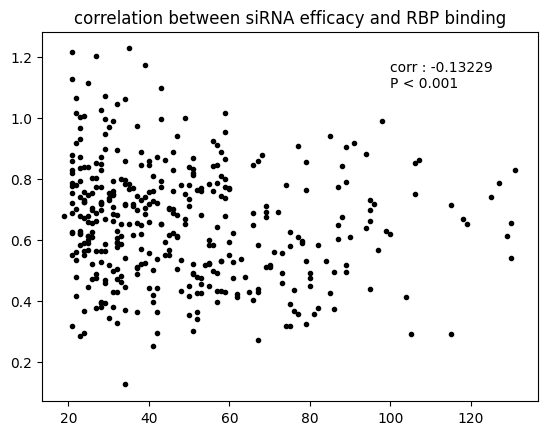

In [629]:
df['RBP_overlap'] = df['ID']
EXPAND = 0
# def RBP_score(x,k):
#     return sum(x[(x['start'] - EXPAND < int(df.iloc[k,3])) & (x['end'] + EXPAND > int(df.iloc[k,4]))]['PhastCons score'])
def RBP_score(x,k):
    TMP = x[(x['start'] - EXPAND < int(df.iloc[k,3])) & (x['end'] + EXPAND > int(df.iloc[k,4]))]
    if not TMP.empty:
        for m in range(TMP.shape[0]):       
            if int(TMP.iloc[m,-2]) < int(df.iloc[k,3]):
                return max((TMP.iloc[m,-1] - int(df.iloc[k,3])),(int(df.iloc[k,4]) - int(df.iloc[k,3])))
            else:
                return min(  (int(df.iloc[k,4]) -  TMP.iloc[m,-2]),(TMP.iloc[m,-1] - TMP.iloc[m,-2])   )
    else:
        return 0

for n in mRNA_list:
    for i in df[(df['ID'] == n).values].index:
        df.iloc[i,8] = RBP_score(mRNA_dict[n],i)

tmp = df[(df['RBP_overlap'] != 0).values[:,0]]
a1 = pd.Series(list(tmp['RBP_overlap'].values[:,0]))
a2 = pd.Series(list(tmp['efficacy'].values[:,0]))
print(a1.corr(a2))
plt.scatter(a1, a2, c = 'black',marker = '.')
plt.title('correlation between siRNA efficacy and RBP binding')

#correlation P value reference:
#0.001: 0.104
#0.005: 0.089
#0.01: 0.081
#0.05: 0.062
#0.1: 0.052
plt.text(100,1.1,'corr : ' + str(round(a1.corr(a2),5)) + '\nP < 0.001')
plt.savefig('figure/RBP/Correlation_without0.png')
plt.show()
